# Transformer 

- [Attention Is All You Need 2017](https://arxiv.org/pdf/1706.03762) 논문에서 제시한 모델로 RNN모듈을 사용하지 않고 **Attention 모듈로만 구성한 Encoder-Decoder 구조의 seq2seq 모델**이다.
    - RNN → RNN + attention → Transformer
- Transformer 이후 자연어 관련 pretrained 모델들은 대부분 Transformer의 Encoder나 Decoder를 변형하거나 단순히 층을 깊게 쌓는 형태로 구현하여 성능을 올렸다.
    - Google의 BERT(Bidirectional Encoder Representations from Transformers)는 Transformer의 Encoder를 이용해 구현했다.
    - OpenAI의 GPT(Generative Pre-trained Transformer)는 Transformer의 Decoder를 이용해 구현했다.

## Seq2Seq의 문제와 Transformer
- Seq2Seq 의 문제
    - 장기기억 소실의 문제.(long term dependency problem)
        - seq가 길어지면 초기 timestep의 정보가 점점 소실된다.
    - 병렬처리를 못해 연산 효율이 떨어진다.
        - time step **순서대로** 처리해야 하기 때문에 병렬처리가 안된다.
- **장기기억 소실문제는** seq2seq에 **Attention mechanism**을 적용해 해결할 수 있다.
  
![img](figures/transformer_advantage.gif)
- Transformer는  encoder와 decoder에서 RNN을 제거하고 **Attention 모듈로 변경하여 병렬 처리가 가능**하도록 했다.

## Transformer Architecture
- Encoder - Decoder  구조
- Encoder와 Decoder가 **self-attention 모듈**로 구성된다. 그래서 RNN을 쓰지 않고 입력 sequence와 출력 sequence를 처리한다.
- **Positional Encoding**
    - RNN을 사용하지 않기 때문에 입력 sequence의 토큰들에 순서정보가 없다. 그 순서정보를 Embedding에 추가하는 역할.
    - 문장을 구성하는 각 토큰들의 embedding vector에 그 토큰 순서 정보를 가지는 positional encoding 값을 더해준다.
    - Positional Encoding 값은 sine/cosin 주기함수를 이용해 계산한다.

![img](figures/transformer_architecture2.png)

\[**transformer의 구조**\]

![img](figures/transformer_architecture1.png)

\[**Encoder와 Decoder의 구조**\]

## Self Attention
- Attention을 자기 자신한테 적용한다는 의미
    - seq2seq 의 attention은 decoder의 sequence가 encoder의 hidden state에 attention을 취한다. (디코더가 인코더의 어디에 집중할 지 찾는다.)
    - self attention은 attention을 자기 자신에게 취한다. (같은 문장 내에서 단어들이 서로 어떤 관계를 가지는지 찾는다.)
- Self-attention은 하나의 단어가 자신이 속한 문장의 다른 단어들과 어떤 연관성을 가지는지 찾는다.

![img](figures/transformer_self-attention.png)

- 예를 들어 "The animal didn't cross the street because it was too tired." 라는 문서에 있는  `it`을 encoding 한려고 한다. 
- `it`을 문맥에 맞게 embedding하기 위해서는 이 문서안에서 어떤 의미로 쓰였는지 알아야 한다. 
- 그것을 알기 위해서는 `it` 이 가리키는(관련있는) 것이 어떤 것인지 알아야 한다. 그것을 다른 문서에서 찾는 것이 아니라 `it` 있는(대상 단어가 있는) 문서에서 다른 단어들과의 연관성에서 찾는다.
- **의미를 파악하려는 문서와 그 의미를 찾는 문서가 동일하기 때문에 self-attention**이라고 한다.

### Self Attetion 과정
- 같은 문장내에서 단어들 간의 관계를 고려하는 것.
  
![self-attention](figures/transformer_self_attention.png)

- **수식**
\begin{align}
&\text{Attention(Q,K,V)} = \text{softmax}(\cfrac{QK^T}{\sqrt{d_k})})V \\
&\small \text{Q: Query, K: Key, V: Value,}\;d_{k}: \text{emmbeding 차원}
\end{align}

In [1]:
import torch
import math
import matplotlib.pyplot as plt

class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        
        # (max_len, d_model) shape의 positional encoding 텐서 생성
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)  # (max_len, 1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))  # (d_model/2,)

        # 짝수 위치에는 sin, 홀수에는 cos 적용
        pe[:, 0::2] = torch.sin(position * div_term)   # even indices
        pe[:, 1::2] = torch.cos(position * div_term)   # odd indices

        pe = pe.unsqueeze(0)  # shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)  # 학습되지 않는 고정된 값

    def forward(self, x):
        """
        Args:
            x: (batch_size, seq_len, d_model)
        Returns:
            x + positional_encoding
        """
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len, :]


In [2]:
d_model = 512
seq_len = 50
batch_size = 32

# 가짜 입력: 임베딩 결과라고 가정
x = torch.randn(batch_size, seq_len, d_model)

# Positional Encoding 적용
pe = PositionalEncoding(d_model=d_model)
x_pe = pe(x)  # x + position info


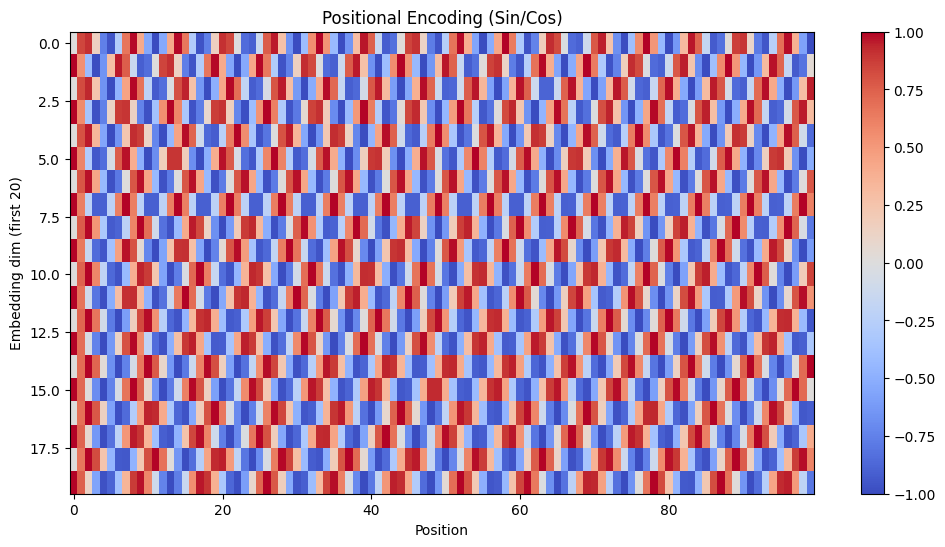

In [3]:
pe_matrix = pe.pe[0, :100].detach().numpy()  # (100, d_model)
plt.figure(figsize=(12, 6))
plt.imshow(pe_matrix.T[:20], cmap='coolwarm', aspect='auto')
plt.xlabel("Position")
plt.ylabel("Embedding dim (first 20)")
plt.title("Positional Encoding (Sin/Cos)")
plt.colorbar()
plt.show()


1. Query, Key, Value 생성
    - **Query**: Embedding vector를 구할 대상 (ex: it)
    - **Key**: Query와 연관성있는 단어들을 계산할 대상 (ex: 위 그림의 왼쪽 문서 토큰들)
    - **Value**: Query와 Key를 이용해 찾은 attention weight를 적용해 Attention value를 찾을 대상. 
    - Self attention은 Query, Key, Value 모두 입력 Sequence(X)로 부터 생성한다.
       - X에 각각 다른 Weight를 내적하여 만든다.
         - $Query=X\cdot W_q$ 
         - $Key=X\cdot W_k$ 
         -  $Value=X\cdot W_v$

![img](figures/transformer_query_key_value.png)

2. **Attention Score**
    - Query 와 Key를 내적(dot product)하여 유사도를 계산한다. embedding vector의 차원의 제곱근으로 나눠서 정규화한다.
    - Scaled Dot Product Attention
   $$
   \text{Attention Score} = \cfrac{Q\cdot K^T}{\sqrt{d_k}}
   $$
![img](figures/transformer_query_key_matmulpng.png)

4. **Attention Weight(Distribution)**
   - 위에서 계산된 Attention score에 softmax를 적용해 0 ~ 1 사이 비율로 바꾼다.
     
   $$
    \text{Attention Weight} = softmax(\text{Attention Score})
   $$

5. **Attention value**
   - 최종 attention 연산의 결과로 **Attention weight를 Value에 내적**해서 Attention Value를 만든다.
   - Attention에서 Attention value값이 **입력 sequence의 context vector**가 된다.
   $$
   \text{Attention Value} = \text{Attention Weight}\cdot\text{Value}
   $$ 
![img](figures/transformer_attention_value.png)

## Multi-Head attention
- Multi-Head Attention 은 입력 데이터의 Attention Value를 계산하는 Query, Key, Value의 weight들을 하나가 아니라 여러개로 작게 나눠서 계산한다.
- 이렇게 나눈 것을 head라고 하고 여러개를 만들어 사용하므로 multi-head attention이라고 한다.
- **분할 과정**
    - 입력 Embedding Vector가 512차원이고 Head를 8개 사용한다고 할 경우
    - Head는 64차원(512/8) 의 서로 다른 weight를 가진 Query, Key, Value를 8개 생성한다. (Single Head는 512차원 한개의 Query, Key, Value 생성)
        - 입력 차원이 head 수로 나누어떨어지는 경우에만 head 분할이 가능하다.  `입력차원 % head수 = 0` 이어야 한다.
    - 각 head는 독립적으로 Attention 연산을 수행한다. (**병렬 처리**)
    - 모든 head의 출력을 concat한 후, 최종적으로 출력 차원을 원래 차원으로 매핑하기 위해 추가적인 선형 변환을 수행한다.
- **장점**
    -  동일한 입력 시퀀스에 대해 여러 관점(문법적 관계, 의미적 관계 등)에서의 정보를 동시에 학습할 수 있다.
    -  각 head가 서로 다른 특성을 학습하여 더 풍부한 표현이 가능하다.
    - 여러 head의 연산이 병렬적으로 처리될 수 있어 GPU와 같은 하드웨어에서 연산 속도를 극대화할 수 있다.


![img](figures/transformer_multi-head-attention.png)

## Masked self Attention
- 입력 sequence 가 순서대로 입력되어 처리 되는 경우 i번째 입력 단어의 경우 그 이후의 단어는 모르는 상태이다. 
- Attention은 입력된 모든 토큰을 한번에 처리해버리기 때문에 attention score를 구할 수있게 된다. 이것은 주어진 토큰(i번째)이 미래시점의 입력토큰(i+1 이후 번째)과의 유사도를 계산한 것이 된다. 
- 이 문제를 해결하기 위해 i번째 토큰에 대한 attention score는 i번째 까지의 토큰들과만 계산하도록 한다.
- Attention Score를 Softmax 계산하기 전에 적용한다.
- Attention 계산시 선택적으로 mask를 사용하면 Masked self attention이 된다. (Masked Multi-Head Attention)
![img](figures/transformer_masked_self_attention.png)

# Transfomer 모델의 구조적 분류와 대표모델

- Transfomer 모델을 기반으로 구현된 다양한 모델들이 있다. 
- 트랜스포머 모델은 구조에 따라 크게 세 가지로 분류할 수 있었다.

## 인코더 전용 모델 (Encoder-Only)
- Transformer Encoder 구조를 이용해 구현된 모델들. 
- **대표 모델들**:
    - BERT: 마스크드 언어 모델링과 다음 문장 예측을 목표로 하는 모델.
    - RoBERTa: BERT를 개선하여 더 많은 데이터와 더 큰 배치로 성능을 향상시킨 모델.
    - ALBERT: 파라미터 수를 줄이고 레이어 간 파라미터를 공유하도록 개선한 모델.

## 디코더 전용 모델 (Decoder-Only)
- Transformer Decoder 구조를 이용해 구현된 모델들. 
- **대표 모델들**:
    - GPT 시리즈: 텍스트 생성에 특화된 모델로, GPT-1부터 GPT-3까지 발전했다
    - CTRL: 제어 토큰을 추가하여 생성 문장의 스타일을 제어할 수 있는 모델
    - OPT: GPT와 유사한 구조를 가진 오픈 소스 모델

## 인코더-디코더 모델 (Encoder-Decoder)
- Transformer의 Encoder-Decoder 구조를 이용해 구현된 모델들.
- **대표 모델들**:
    - T5: 모든 NLP 태스크를 텍스트-투-텍스트 형식으로 변환하여 처리하는 모델
    - BART: BERT의 인코더와 GPT의 디코더를 결합한 모델
    - M2M-100: 100개 언어 간 번역이 가능한 다국어 번역 모델
    - BigBird: 긴 시퀀스를 처리할 수 있도록 개선된 모델

![transformer_models.png](figures/transformer_models.png)

<대표적인 transformers 기반 모델들>